In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, transpile
from qiskit_ibm_provider import IBMProvider
from qiskit.tools.monitor import job_monitor
from qiskit.tools.visualization import plot_histogram
%matplotlib inline

In [2]:
provider = IBMProvider()

In [3]:
def generate_function(s, filename=None):
    in_reg = QuantumRegister(len(s), 'in')
    out_reg = QuantumRegister(1, 'out')
    oracle = QuantumCircuit(name='Oracle')
    oracle.add_register(in_reg)
    oracle.add_register(out_reg)

    for idx, digit in enumerate(reversed(s)):
        if digit == '1':
            oracle.cx(idx, len(s))

    return oracle, oracle.draw('mpl', filename=filename)

In [4]:
def form_bv_circuit(oracle):
    input_size = oracle.num_qubits - 1

    input_register = QuantumRegister(input_size, 'in')
    output_register = QuantumRegister(1, 'out')
    result_register = ClassicalRegister(input_size, 'res')

    result_circuit = QuantumCircuit()
    result_circuit.add_register(input_register)
    result_circuit.add_register(output_register)
    result_circuit.add_register(result_register)

    # Prepare state
    result_circuit.x(input_size)
    result_circuit.h(range(input_size + 1))
    result_circuit.barrier()

    # Call oracle
    result_circuit.append(oracle, range(input_size + 1))
    result_circuit.barrier()

    # Get result
    result_circuit.h(range(input_size))
    result_circuit.measure(range(input_size), range(input_size))

    return result_circuit

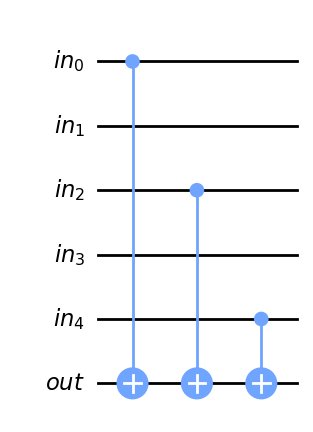

In [5]:
gate, circuit_image = generate_function('10101', filename='oracle.pdf')
circuit_image

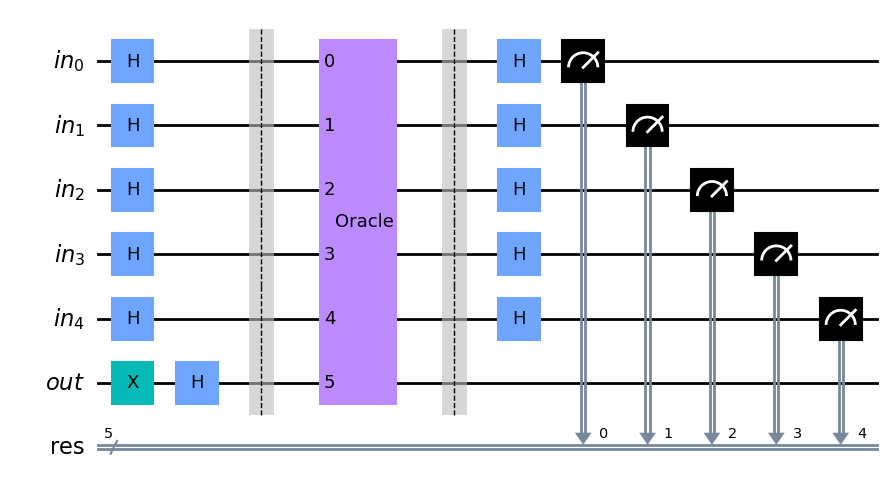

In [6]:
bv_circuit = form_bv_circuit(gate)
bv_circuit.draw('mpl')

In [7]:
simulator = Aer.get_backend('aer_simulator')
circ = transpile(bv_circuit, simulator)

counts = simulator.run(circ).result().get_counts()

In [8]:
counts

{'10101': 1024}

In [ ]:
backend = provider.backends().get_backend('ibmq_manila')
transpiled_bv_circuit = transpile(bv_circuit, backend)

job = backend.run(transpiled_bv_circuit, shots=1024)
print(job.job_id())
job_monitor(job, interval=2)

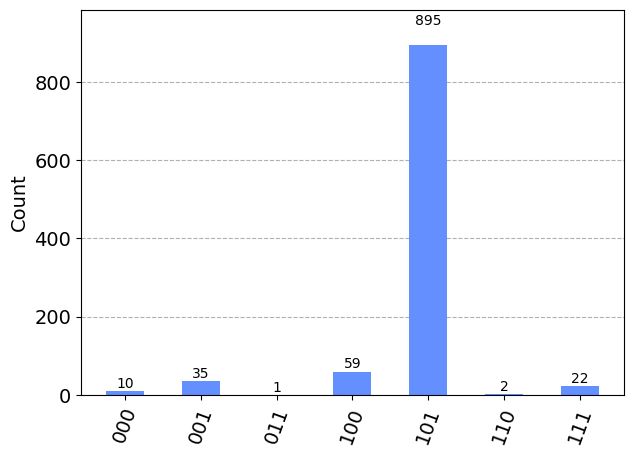

In [9]:
job = provider.retrieve_job('cgn7fsmmln5fjas58k30')
counts = job.result().get_counts()
plot_histogram(counts)